In [1]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [11]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


In [12]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [13]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

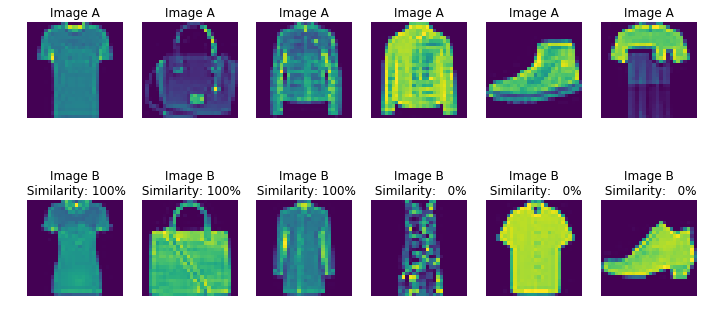

In [14]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [15]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 16)        0         
__________

In [16]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Model)  (None, 32)           25040       ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 64)           0           FeatureGenerationModel[1][0]     
          

In [17]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

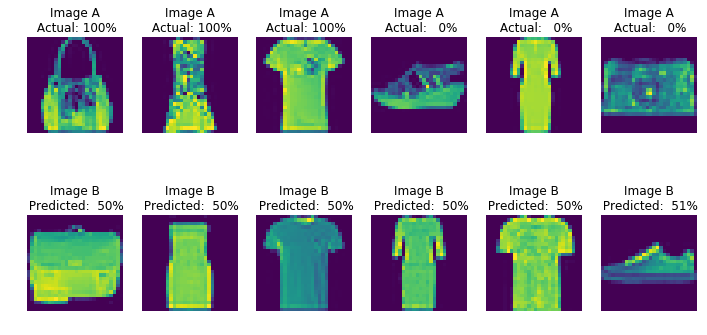

In [18]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [19]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 500,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                             verbose = True)

Epoch 1/10
500/500 [==============================] - 54s 108ms/step - loss: 0.6816 - mean_absolute_error: 0.4782 - val_loss: 0.6066 - val_mean_absolute_error: 0.4444
Epoch 2/10
500/500 [==============================] - 49s 98ms/step - loss: 0.5882 - mean_absolute_error: 0.4248 - val_loss: 0.5376 - val_mean_absolute_error: 0.3700
Epoch 3/10
500/500 [==============================] - 49s 98ms/step - loss: 0.5165 - mean_absolute_error: 0.3652 - val_loss: 0.4603 - val_mean_absolute_error: 0.2916
Epoch 4/10
500/500 [==============================] - 49s 98ms/step - loss: 0.4458 - mean_absolute_error: 0.3064 - val_loss: 0.4079 - val_mean_absolute_error: 0.2605
Epoch 5/10
500/500 [==============================] - 49s 98ms/step - loss: 0.4139 - mean_absolute_error: 0.2764 - val_loss: 0.3949 - val_mean_absolute_error: 0.2356
Epoch 6/10
500/500 [==============================] - 49s 99ms/step - loss: 0.3958 - mean_absolute_error: 0.2619 - val_loss: 0.3777 - val_mean_absolute_error: 0.2275
Epo

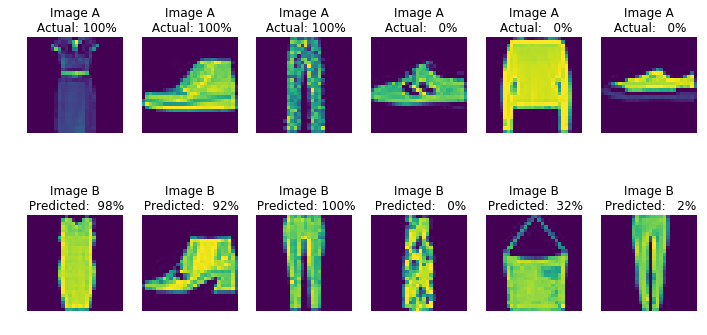

In [20]:
_ = show_model_output()

In [21]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

10000/10000 [==============================] - 7s 654us/step


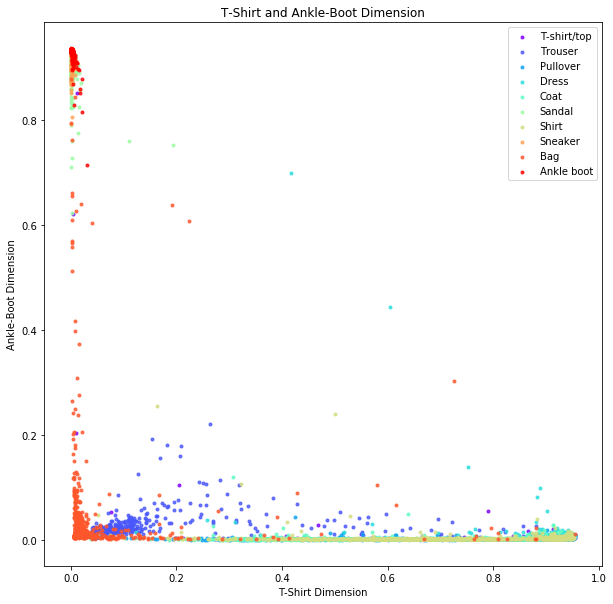

In [22]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [23]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

10000/10000 [==============================] - 3s 340us/step


In [24]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.064s...
[t-SNE] Computed neighbors for 10000 samples in 1.407s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.140431
[t-SNE] Computed conditional probabilities in 0.797s
[t-SNE] Iteration 50: error = 76.1249161, gradient norm = 0.0024850 (50 iterations in 8.590s)
[t-SNE] It

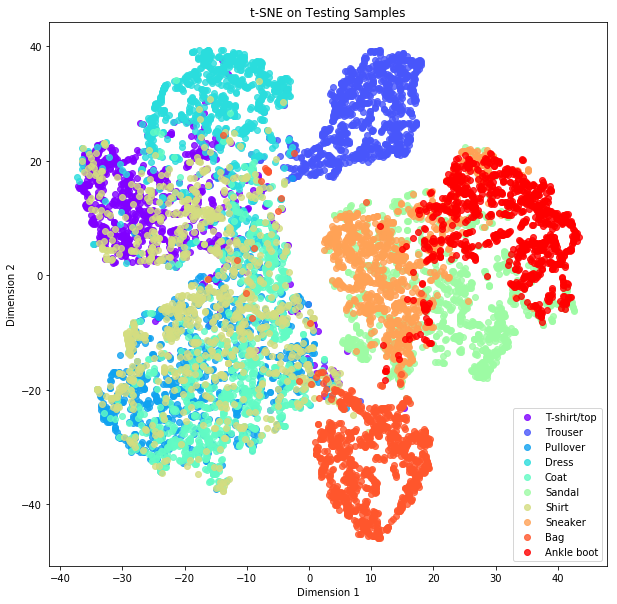

In [25]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

In [26]:
feature_model.save('fashion_feature_model.h5')

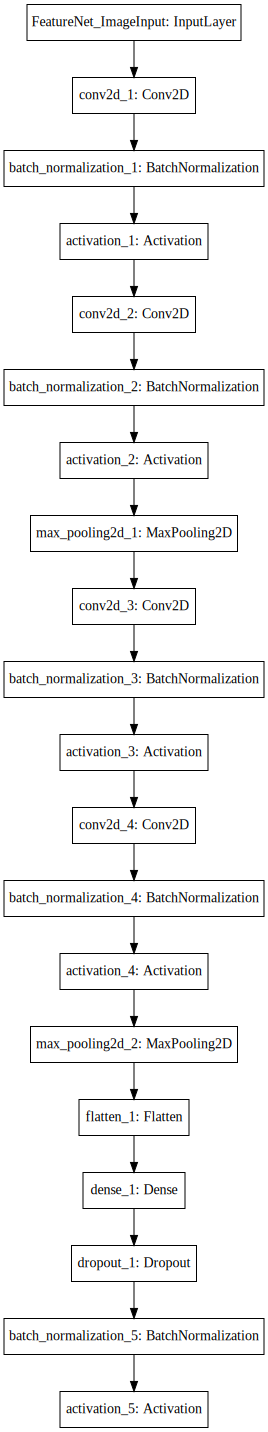

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(feature_model).create(prog='dot', format='svg'))